In [81]:
# In this notebook, we run the information monotonicity experiments
# All performance measures are computed with the function 'compute_performance'
# The results are saved to 'results_L2KL_9nodes_5l_bw005_30ep_seed0.pt'
# We check via kde plot if the kernel bandwidth is appropriate
# Figure 3 in the paper is plotted in the second-to-last cell

import json
import seaborn as sns
import pandas as pd

import torch
from torch.nn import Module, Linear, CrossEntropyLoss, Conv2d, Dropout2d
from torch.nn.functional import relu
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib.pyplot import imshow
from tqdm import trange
import torch.nn.functional as F

from src.calibration_error.bregman_ce import (
    get_bregman_stats_via_risk_l2, get_classwise_bregman_stats_via_risk_l2,
    get_bregman_stats_via_risk_kl, get_classwise_bregman_stats_via_risk_kl,
    get_bregman_stats_via_risk_IS
)

torch.manual_seed(0)
device = 'cpu'

# helper function to compute the accuracy
def accuracy(predictions, targets):
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(predictions, 1)
    total = targets.size(0)
    correct = (predicted == targets).sum().item()

    return 100 * correct / total

In [2]:
### LOAD TRAINING SET ###
transform = transforms.Compose([transforms.ToTensor()])

mnist_train = MNIST('data/', train=True, transform=transform, download=True)

print('Shape of training set tensor:')
print(mnist_train.data.shape)
print('Label distribution:')
print(mnist_train.targets.bincount())

Shape of training set tensor:
torch.Size([60000, 28, 28])
Label distribution:
tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])


In [3]:
### LOAD TEST SET ###
mnist_test = MNIST('data/', train=False, transform=transform)

print('Shape of test set tensor:')
print(mnist_test.data.shape)
print('Label distribution:')
print(mnist_test.targets.bincount())

Shape of test set tensor:
torch.Size([10000, 28, 28])
Label distribution:
tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])


In [4]:
### PREPARE DATA LOADERS ###
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def beta_kernel(z, zi, bandwidth=0.1):
    p = zi / bandwidth + 1
    q = (1-zi) / bandwidth + 1
    z = z.unsqueeze(-2)

    log_beta = torch.lgamma(p) + torch.lgamma(q) - torch.lgamma(p + q)
    log_num = (p-1) * torch.log(z) + (q-1) * torch.log(1-z)
    log_beta_pdf = log_num - log_beta

    return log_beta_pdf

def plot_hist_vs_kde(sigmoid_scores, bandwidth):
    plt.show()
    fig, ax = plt.subplots(1, 2, figsize=(14, 8))
    X_plot = np.linspace(0, 1, 100).squeeze()
    bins = np.linspace(0, 1, 100)
 
    X = sigmoid_scores.detach().numpy()
    ax[0].hist(X[:], bins=bins, density=True, label='Histogram from samples', zorder=5, edgecolor='k', alpha=0.5)
 
    sum1 = np.zeros(len(X_plot))
    for i in range(0, len(X)):
        kern = torch.exp(beta_kernel(torch.tensor(X_plot), sigmoid_scores[i], bandwidth).squeeze())
        kern = torch.nan_to_num(kern).detach().numpy()
        kern = kern / len(X)
        ax[1].plot(X_plot, kern, linestyle="dashed")
        sum1 += kern.squeeze()
 
    plt.title(f"bandwidth = {bandwidth}")
    ax[1].fill(X_plot, sum1, '-k', fc='#AAAAFF')
    ax[1].plot(X_plot, sum1, lw=2, zorder=10)
    plt.xlim(0, 1)
    plt.ylim(0)
    plt.show()

In [6]:
# multi-layer perceptron
class MLP(Module):

    # define model architecture
    def __init__(self, num_classes, hidden_nodes=32):
        super(MLP, self).__init__()
        self.hidden_layer_1 = Linear(28 * 28, hidden_nodes)
        self.hidden_layer_2 = Linear(hidden_nodes, hidden_nodes)
        self.hidden_layer_3 = Linear(hidden_nodes, hidden_nodes)
        self.hidden_layer_4 = Linear(hidden_nodes, hidden_nodes)
        self.output_layer = Linear(hidden_nodes, num_classes)

    # define ouput computation
    def forward(self, image):
        x = image.view(-1, 28 * 28)
        x1 = self.hidden_layer_1(x)
        x1 = relu(x1)
        x2 = self.hidden_layer_2(x1)
        x2 = relu(x2)
        x3 = self.hidden_layer_3(x2)
        x3 = relu(x3)
        x4 = self.hidden_layer_4(x3)
        x4 = relu(x4)
        # logits are predictions before softmax
        logits = self.output_layer(x4)
        output = {'layer_1': x1, 'layer_2': x2, 'layer_3': x3, 'layer_4': x4, 'logits': logits}
        return output

In [7]:
def run_epoch(model, optimizer, data_loader, device):

    for inputs, targets in data_loader:
        inputs = inputs.to(device=device)
        targets = targets.to(device=device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward propagation
        output = model(inputs)
        loss = torch.nn.functional.cross_entropy(output['logits'], targets)
        # back propagation
        loss.backward()
        # gradient step on model parameters
        optimizer.step()

In [44]:
def compute_performance(model, data_loader, device, log_mis=False):
    all_targets = []
    all_layer_1 = []
    all_layer_2 = []
    all_layer_3 = []
    all_layer_4 = []
    all_logits = []

    # disable tracking computations (no backpropagation during testing)
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device=device)
            targets = targets.to(device=device)

            output = model(inputs)
            all_targets.append(targets)
            all_logits.append(output['logits'])
            all_layer_1.append(output['layer_1'])
            all_layer_2.append(output['layer_2'])
            all_layer_3.append(output['layer_3'])
            all_layer_4.append(output['layer_4'])

        # list of tensors to tensor
        all_targets = torch.cat(all_targets)
        all_logits = torch.cat(all_logits)
        all_layer_1 = torch.cat(all_layer_1)
        all_layer_2 = torch.cat(all_layer_2)
        all_layer_3 = torch.cat(all_layer_3)
        all_layer_4 = torch.cat(all_layer_4)

        bandwidth = 0.005
        EPS = 1e-7
        mis = []
        scores_all = []
        if log_mis:
            for k, values in zip(['logits', 'layer_1', 'layer_2', 'layer_3', 'layer_4'], [all_logits, all_layer_1, all_layer_2, all_layer_3, all_layer_4]):
            # for k, values in zip(['logits', 'layer_1', 'layer_2'], [all_logits, all_layer_1, all_layer_2]):
                # pad to make softmax bijective
                m = torch.nn.ConstantPad2d((0, 1, 0, 0), 0)
                padded_values = m(values)
                scores = torch.softmax(padded_values, dim=1)
                scores = torch.clamp(scores, min=EPS, max=1 - EPS)
                _, rf_l2, sh_l2 = get_bregman_stats_via_risk_l2(scores, all_targets, bandwidth=bandwidth, device=device)
                _, rf_kl, sh_kl = get_bregman_stats_via_risk_kl(scores, all_targets, bandwidth=bandwidth, device=device)
                result = {
                    'Layer': k, 
                    'RF L2': rf_l2.item(),
                    'RF KL': rf_kl.item(),
                    'SH L2': sh_l2.item(),
                    'SH KL': sh_kl.item(),
                }
                mis.append(result)
                scores_all.append(scores)
        
        test_acc = accuracy(all_logits, all_targets)

    return {'test_acc': test_acc, 'mis': mis, 'scores': scores_all}

In [62]:
torch.manual_seed(0)
# Define model, optimizer, and loss function instance
model = MLP(num_classes=10, hidden_nodes=9).to(device=device)
optimizer = SGD(model.parameters(), lr=1e-2)

In [63]:
log_mis = True
# check initial performance
result_init = compute_performance(model, test_loader, device=device, log_mis=log_mis)
print(result_init['test_acc'])
print(result_init['mis'])

9.58
[{'Layer': 'logits', 'RF L2': 0.10034947394999909, 'RF KL': 0.0, 'SH L2': -9.460500009356165e-07, 'SH KL': nan}, {'Layer': 'layer_1', 'RF L2': 0.12091447121410603, 'RF KL': -2.2091364118902557, 'SH L2': 0.02056405121410601, 'SH KL': 0.09171195317756631}, {'Layer': 'layer_2', 'RF L2': 0.10086320457825144, 'RF KL': -2.2982466862996236, 'SH L2': 0.0005127845782514212, 'SH KL': 0.00260167876819839}, {'Layer': 'layer_3', 'RF L2': 0.10044287281693252, 'RF KL': -2.3003923114864913, 'SH L2': 9.245281693250063e-05, 'SH KL': 0.0004560535813307176}, {'Layer': 'layer_4', 'RF L2': 0.10036166761983145, 'RF KL': -2.3007939581265253, 'SH L2': 1.124761983142819e-05, 'SH KL': 5.440694129665857e-05}]


In [64]:
result_epochs = [result_init]
pbar = trange(30)
for i in pbar:
    run_epoch(model, optimizer, train_loader, device=device)
    result = compute_performance(model, test_loader, device=device, log_mis=log_mis)
    result_epochs.append(result)
    pbar.set_description("Test Acc: {}".format(result['test_acc']))

Test Acc: 88.54: 100%|██████████████████████████| 30/30 [42:56<00:00, 85.88s/it]


In [65]:
# save results to disk
torch.save(result_epochs, "results_L2KL_9nodes_5l_bw005_30ep_seed0.pt")

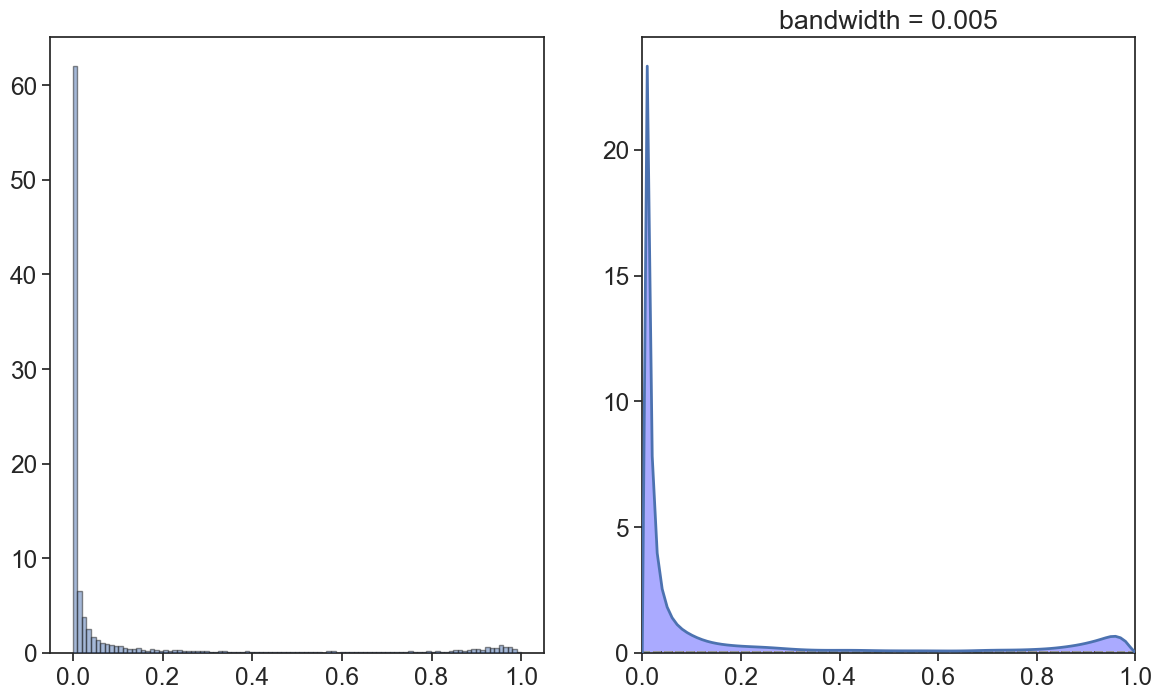

In [66]:
# check if our bandwidth is decent
sigmoid_scores = result_epochs[20]['scores'][0][:,9]
plot_hist_vs_kde(sigmoid_scores, bandwidth=0.005)

In [67]:
mis_df = pd.DataFrame([
    mi | {'epoch': epoch}
    for (epoch, result) in enumerate(result_epochs)
    for mi in result['mis']
])
mis_df

,Layer,RF L2,RF KL,SH L2,SH KL,epoch
0,logits,0.100349,0.000000,-9.460500e-07,NaN,0
1,layer_1,0.120914,-2.209136,2.056405e-02,0.091712,0
2,layer_2,0.100863,-2.298247,5.127846e-04,0.002602,0
3,layer_3,0.100443,-2.300392,9.245282e-05,0.000456,0
4,layer_4,0.100362,-2.300794,1.124762e-05,0.000054,0
...,...,...,...,...,...,...
150,logits,0.939806,0.000000,8.394554e-01,NaN,30
151,layer_1,0.885161,-0.215306,7.848108e-01,2.085543,30
152,layer_2,0.852817,-0.270899,7.524668e-01,2.029949,30
153,layer_3,0.832984,-0.313819,7.326339e-01,1.987029,30


/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_73507/2171817199.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.figure.show();


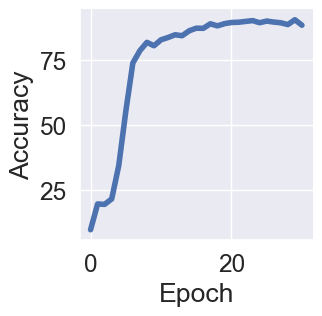

In [78]:
plt.figure(figsize=(3, 3))
plt.style.use("ggplot")
sns.set_palette("tab10")
sns.set(font_scale=1.6)
line_size = 4

# output layer breaks the monotoncity (todo: better estimator)
plot = sns.lineplot([result['test_acc'] for result in result_epochs], linewidth=line_size)
sns.despine(plot.figure)
plot.set_ylabel("Accuracy")
plot.set_xlabel("Epoch")
plot.figure.savefig('info_mono_plot_acc.pdf', bbox_inches='tight')
plot.figure.show();

/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_73507/2588368493.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.figure.show();


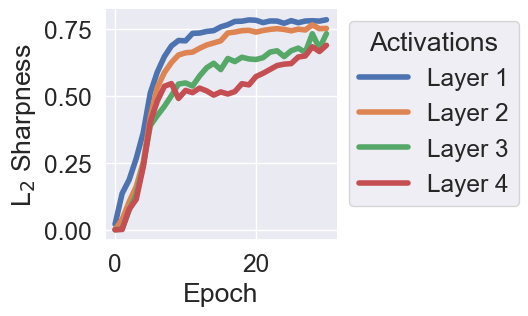

In [79]:
# Figure 3 in the paper
plt.figure(figsize=(3, 3))
plt.style.use("ggplot")
sns.set_palette("tab10")
sns.set(font_scale=1.6)
line_size = 4

sub_df = mis_df[mis_df['Layer'].isin(['layer_1', 'layer_2', 'layer_3', 'layer_4'])].copy()
sub_df.replace({'layer_1': 'Layer 1', 'layer_2': 'Layer 2', 'layer_3': 'Layer 3', 'layer_4': 'Layer 4'}, inplace=True)
sub_df['Activations'] = sub_df['Layer']
plot = sns.lineplot(data=sub_df, y='SH L2', x='epoch', hue='Activations', linewidth=line_size)
sns.despine(plot.figure)
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
plot.set_ylabel("L$_2$ Sharpness")
plot.set_xlabel("Epoch")
plot.figure.savefig('info_mono_plot_l2.pdf', bbox_inches='tight')
plot.figure.show();

/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_73507/3977717895.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.figure.show();


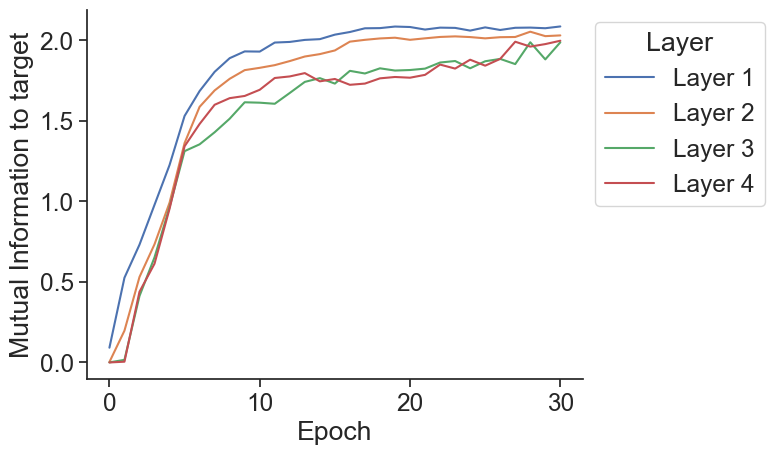

In [70]:
plot = sns.lineplot(data=sub_df, y='SH KL', x='epoch', hue='Layer')
sns.despine(plot.figure)
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
plot.set_ylabel("Mutual Information to target")
plot.set_xlabel("Epoch")
plot.figure.savefig('info_mono_plot_kl.pdf', bbox_inches='tight')
plot.figure.show();